# USE SPECIFIC HUMIDITY EVERYWHERE INSTEAD OF MIXINGRATIO (see calculate_most.ipynb)

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

import xarray as xr
from metpy.units import units
from metpy.calc import specific_humidity_from_mixing_ratio
import pint_xarray
import turbpy
import sys
sys.path.append('/home/elilouis/sublimationofsnow/')
import sosutils
import json
import copy

import scipy.stats

# Inputs

In [2]:
start_date = '20221130'
end_date = '20230509'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [3]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# Find near-snow-surface temperatures using in-snow thermistors

In [4]:
time_interval = pd.Interval(pd.Timestamp(2023,1,31), pd.Timestamp(2023,2,8))
case_study_src = tidy_df_5Min[tidy_df_5Min.time >= time_interval.left]
case_study_src = case_study_src[case_study_src.time < pd.Timestamp(2023,2,8)]

In [5]:
alt.Chart(
    case_study_src.query("measurement == 'snow temperature'")   
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Facet("tower:N"),
    tooltip = 'height'
).properties(width=500)

alt.Chart(...)

0.9 m is the highest thermistor at d tower, 1.2m is highest thermistor at UW tower. Let's compare those temps specifically now

In [6]:
src = case_study_src[case_study_src.variable.isin([
    'Tsurf_rad_d',
    'Tsurf_d', 
    'Tsnow_0_9m_d',
    'Tsurf_uw',
    'Tsnow_1_2m_uw'
])]
alt.Chart(
    src
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable:N"),
    alt.Facet("tower:N"),
).properties(width=500).resolve_scale(color='independent')

alt.Chart(...)

## Define Constants, Extract Variables, Make Unit Conversions 
(as requierd by TurbPy)

In [7]:
# Define constants
VON_KARMAN_CONSTANT = 0.40 #dimensionless
GRAVITY = 9.81 # m/s^2
SNOW_SURFACE_ROUGHNESS = 5e-3 # m, Marks and Dozier report its in the range [1e-4, 5e-3]
ZERO_PLANE_DISPLACEMENT_HEIGHT = 0
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_HEAT = 1.0 # dimensionless
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_WATERVAPOR = 1.0 # dimensionless
AIR_SPECIFIC_HEAT = 1005 # J / kg / K

# Extract variables we want to use
VARIABLES = [
    # Surface temperature options
    'Tsurf_rad_d',
    'Tsurf_d', 
    'Tsurf_c', 
    'Tsnow_0_9m_d',
    'Tsurf_uw',
    'Tsnow_1_2m_uw',
    # Other required input variables
    'spd_3m_c', 
    'spd_3m_uw',
    'mixingratio_3m_c',
    'T_3m_c', 
    'P_10m_c',
    # Turbulent flux measurements (for comparison with model results)
    'w_h2o__3m_c', 
    'w_tc__3m_c', 
    'u*_3m_c',
    'Ri_3m_c'
]
variables_df = case_study_src[case_study_src.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# Conversions
    # convert from ˚C to K
variables_df['Tsurf_rad_d'] = variables_df['Tsurf_rad_d'] + 273.15
variables_df['Tsurf_d'] = variables_df['Tsurf_d'] + 273.15
variables_df['Tsurf_c'] = variables_df['Tsurf_c'] + 273.15
variables_df['Tsnow_0_9m_d'] = variables_df['Tsnow_0_9m_d'] + 273.15
variables_df['Tsurf_uw'] = variables_df['Tsurf_uw'] + 273.15
variables_df['Tsnow_1_2m_uw'] = variables_df['Tsnow_1_2m_uw'] + 273.15
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
# comes in units of g/g
# our solution requires it in units of g/kg
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values

## Add measurement height variables (constants)

In [8]:
variables_df['measurement_height_windspeed'] = 3
variables_df['measurement_height_temperature'] = 3
variables_df['measurement_height_specifichumidity'] = 3

# Use TurbPy

## Define function for running TurbPy

In [9]:
def run_turbpy(
    height,
    snowDepth,
    sfcTemp,
    airTemp,
    windspd,
    airPressure,
    mixing_ratio,
    scheme
):
    # turbpy requires pressure in units of pascals
    airPressure = (airPressure * units.millibar).to(units.pascal).magnitude
    # the turbpy.vapPress function requires specific humidity in units of g/g
    airVaporPress = turbpy.vapPress(
        specific_humidity_from_mixing_ratio(
            xr.DataArray(mixing_ratio)*units('g/kg')
        ).pint.to('g/g').values,
        airPressure
    )

    # requires temp in units ˚C
    (sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)
    
    ## Calculate stability

    stability_correction = np.zeros_like(sfcTemp)
    conductance_sensible = np.zeros_like(sfcTemp)
    conductance_latent = np.zeros_like(sfcTemp)
    sensible_heat = np.zeros_like(sfcTemp)
    latent_heat = np.zeros_like(sfcTemp)
    zeta = np.zeros_like(sfcTemp)

    ## Calculate stability
    for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(
        airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure
    )):
        if any(np.isnan([tair, vpair, tsfc, vpsfc, u, airP])):
            stability_correction[n] = np.nan
            conductance_sensible[n] = np.nan
            conductance_latent[n] = np.nan
            sensible_heat[n] = np.nan
            latent_heat[n] = np.nan
            zeta[n] = np.nan
        else:
            (
                conductance_sensible[n], 
                conductance_latent[n], 
                sensible_heat[n],
                latent_heat[n],
                stab_output,
                p_test
            ) = turbpy.turbFluxes(tair, airP,
                                                    vpair, u, tsfc,
                                                    vpsfc, snowDepth,
                                                    height, param_dict=scheme,
                                                    z0Ground=SNOW_SURFACE_ROUGHNESS, groundSnowFraction=1)
            # Get the Zeta value from the stability parameters dictionary
            if scheme['stability_method'] != 'monin_obukhov':
                stability_correction[n] = stab_output['stabilityCorrection']
                # SHOULD I JUST BE ASSIGNING NAN HERE?
                zeta[n] = stab_output['zeta']
            else:
                stability_correction[n] = np.nan
                zeta[n] = stab_output['zeta']
    
    return stability_correction, conductance_sensible, conductance_latent, sensible_heat, latent_heat, zeta

## Create dataframe with the Turbpy results, our iterative solution results, and our measurement dataset

In [10]:
# add mean of surface temp and snow temp
variables_df['Tsurfsnow_mean_d'] = variables_df[['Tsurf_d', 'Tsnow_0_9m_d']].mean(axis=1)
variables_df['Tsurfsnow_mean_uw'] = variables_df[['Tsurf_uw', 'Tsnow_1_2m_uw']].mean(axis=1)

surface_temp_options = [
    'Tsurf_rad_d',
    'Tsurf_d', 
    'Tsurf_c', 
    'Tsnow_0_9m_d',
    'Tsurf_uw',
    'Tsnow_1_2m_uw',
    'Tsurfsnow_mean_d',
    'Tsurfsnow_mean_uw'
]


for surf_temp_option in surface_temp_options:
    (
        stability_correction, 
        conductance_sensible, 
        conductance_latent, 
        sensible_heat, 
        latent_heat, 
        zeta
    ) = run_turbpy(
        height = 3,
        snowDepth = 0,
        sfcTemp = variables_df[surf_temp_option].values,
        airTemp = variables_df['T_3m_c'].values,
        windspd = variables_df['spd_3m_c'].values,
        airPressure = variables_df['P_10m_c'].values,
        mixing_ratio = variables_df['mixingratio_3m_c'].values,
        scheme = {
                    'stability_method': 'monin_obukhov',
                    'monin_obukhov': {
                        'gradient_function': 'holtslag_debruin'
                    }
                }
    )
    variables_df[f'w_h2o__3m_c modeled ({surf_temp_option})'] = -latent_heat/2838
    variables_df[f'w_tc__3m_c modeled ({surf_temp_option})'] = -sensible_heat
    variables_df[f'obukhov_length modeled ({surf_temp_option})'] = 3 / zeta

## Plot results

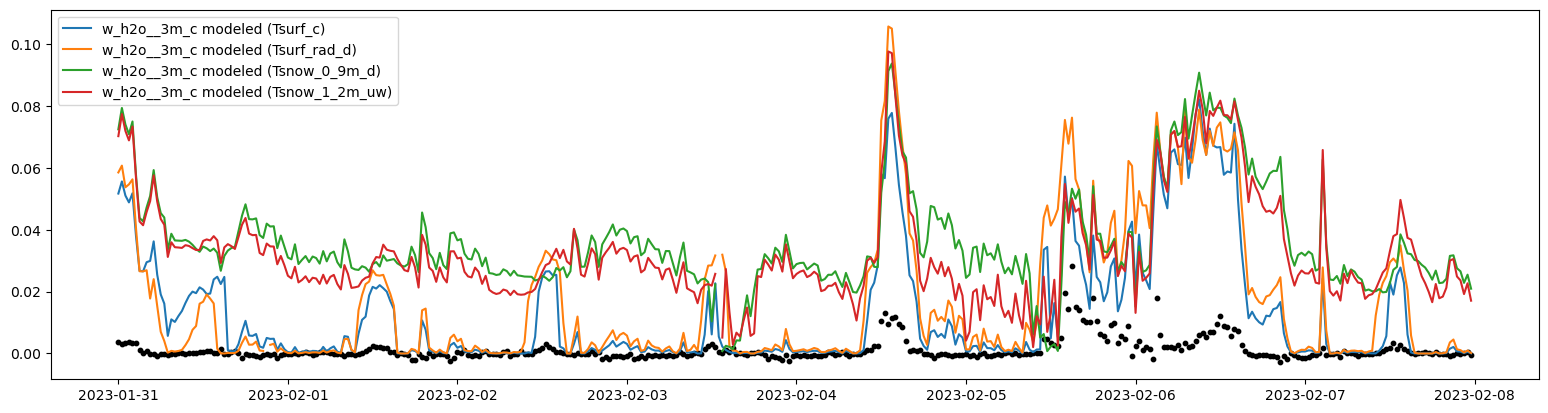

In [11]:
fig, ax = plt.subplots(figsize=(19.2, 4.8))
ax.scatter(variables_df['time'], variables_df['w_h2o__3m_c'], color='k', s=10)
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_c)'], label='w_h2o__3m_c modeled (Tsurf_c)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_rad_d)'], label='w_h2o__3m_c modeled (Tsurf_rad_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsnow_0_9m_d)'], label='w_h2o__3m_c modeled (Tsnow_0_9m_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsnow_1_2m_uw)'], label='w_h2o__3m_c modeled (Tsnow_1_2m_uw)')
plt.legend()
plt.show()

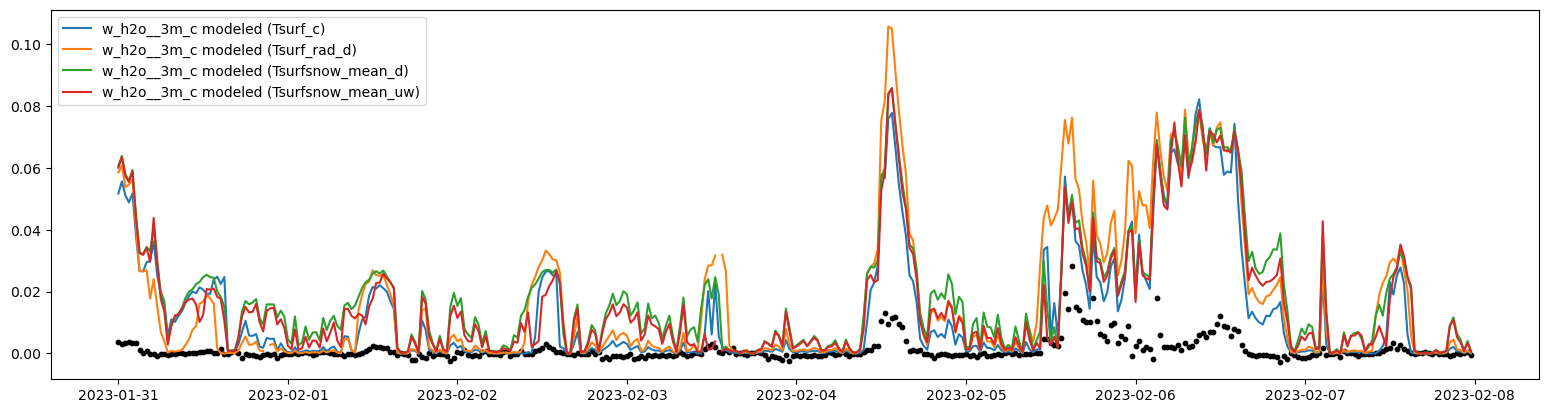

In [12]:
fig, ax = plt.subplots(figsize=(19.2, 4.8))
ax.scatter(variables_df['time'], variables_df['w_h2o__3m_c'], color='k', s=10)
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_c)'], label='w_h2o__3m_c modeled (Tsurf_c)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_rad_d)'], label='w_h2o__3m_c modeled (Tsurf_rad_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_d)'], label='w_h2o__3m_c modeled (Tsurfsnow_mean_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_uw)'], label='w_h2o__3m_c modeled (Tsurfsnow_mean_uw)')
plt.legend()
plt.show()

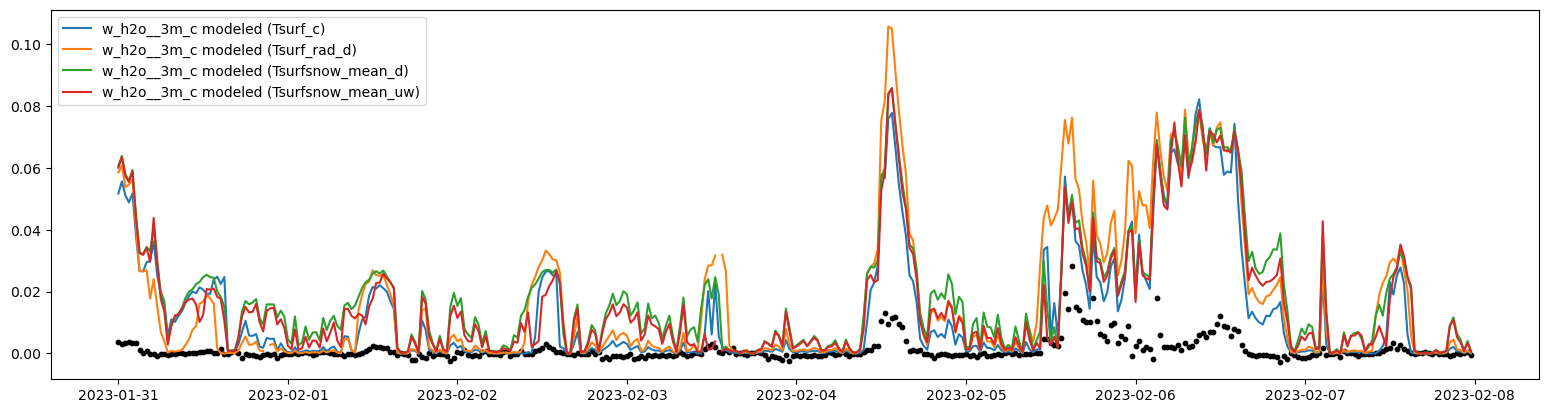

In [13]:
fig, ax = plt.subplots(figsize=(19.2, 4.8))
ax.scatter(variables_df['time'], variables_df['w_h2o__3m_c'], color='k', s=10)
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_c)'], label='w_h2o__3m_c modeled (Tsurf_c)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurf_rad_d)'], label='w_h2o__3m_c modeled (Tsurf_rad_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_d)'], label='w_h2o__3m_c modeled (Tsurfsnow_mean_d)')
ax.plot(variables_df['time'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_uw)'], label='w_h2o__3m_c modeled (Tsurfsnow_mean_uw)')
plt.legend()
plt.show()

(-0.01, 0.05)

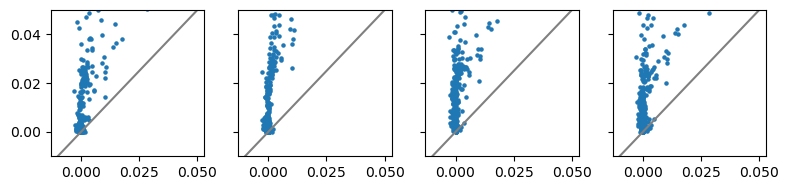

In [14]:
fig, axes = plt.subplots(1,4,figsize=(8,2), sharex=True, sharey=True)
axes[0].scatter(variables_df['w_h2o__3m_c'], variables_df['w_h2o__3m_c modeled (Tsurf_c)'], s=5)
axes[1].scatter(variables_df['w_h2o__3m_c'], variables_df['w_h2o__3m_c modeled (Tsurf_rad_d)'], s=5)
axes[2].scatter(variables_df['w_h2o__3m_c'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_d)'], s=5)
axes[3].scatter(variables_df['w_h2o__3m_c'], variables_df['w_h2o__3m_c modeled (Tsurfsnow_mean_uw)'], s=5)
for ax in axes:
    ax.plot([-0.01,0.05], [-0.01,0.05], color='grey')
plt.tight_layout()
plt.ylim(-0.01, 0.05)

In [15]:

src = variables_df.dropna()
print(scipy.stats.linregress(src['w_h2o__3m_c'].values, src['w_h2o__3m_c modeled (Tsurf_c)'].values)[2]**2)
print(scipy.stats.linregress(src['w_h2o__3m_c'].values, src['w_h2o__3m_c modeled (Tsurf_rad_d)'].values)[2]**2)
print(scipy.stats.linregress(src['w_h2o__3m_c'].values, src['w_h2o__3m_c modeled (Tsurfsnow_mean_d)'].values)[2]**2)
print(scipy.stats.linregress(src['w_h2o__3m_c'].values, src['w_h2o__3m_c modeled (Tsurfsnow_mean_uw)'].values)[2]**2)

0.47473103145787704
0.5753945848763223
0.4137881246676152
0.42596948503027743


In [16]:
print(np.mean((src['w_h2o__3m_c'].values - src['w_h2o__3m_c modeled (Tsurf_c)'].values)/src['w_h2o__3m_c'].values))
print(np.mean((src['w_h2o__3m_c'].values - src['w_h2o__3m_c modeled (Tsurf_rad_d)'].values)/src['w_h2o__3m_c'].values))
print(np.mean((src['w_h2o__3m_c'].values - src['w_h2o__3m_c modeled (Tsurfsnow_mean_d)'].values)/src['w_h2o__3m_c'].values))
print(np.mean((src['w_h2o__3m_c'].values - src['w_h2o__3m_c modeled (Tsurfsnow_mean_uw)'].values)/src['w_h2o__3m_c'].values))

33.036515790777976
49.52272825902701
65.03526236079816
38.56631987069108
